In [ ]:
import pandas as pd
import regex as re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from string import punctuation
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Importing data**

In [ ]:
# Import data

df = pd.read_csv("/content/drive/MyDrive/BART LSTM/occ-mgr-logs-2022-0124-0131.csv")
df

,_time,ENTRY
0,2022-01-28T02:06:00.000-0800,EOR.
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w..."
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.
...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba..."
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.


It seems that the data has no label. Our purpose in this project is to classify the category that this OCC log falls into: (e.g. is this text a request for maintenance).

# **Data Cleaning**

It seems that there are a lot of stopwords that will impact the model. 

Some examples of stopwords (i.e.,not important words) are as follows:

- Txxx
- Mxx-x
- etc.

Where x represents digits.

The function called `text_cleaning` is used for text cleaning the log column. This function will generate new column called `cleaned_log`.

In [ ]:
# Functions for text cleaning
def removeDigit(lst): 
    pattern = '[0-9]'
    lst = [re.sub(pattern, '', i) for i in lst] 
    return lst

def remove_punctuation(document):
    no_punct = ''.join([character for character in document if character not in punctuation])
    return no_punct

def remove_digit(document): 
    no_digit = ''.join([character for character in document if not character.isdigit()])         
    return no_digit

stop_words = set(stopwords.words('english'))
def remove_stopwords(document):
    words = [word for word in document if not word in stop_words]
    return words

porter = PorterStemmer()

def stemmer(document):
    stemmed_document = [porter.stem(word) for word in document]
    return stemmed_document

In [ ]:
def text_cleaning(df):

  # Initialize
  df['cleaned_entry'] = df['ENTRY']

  # Remove stop words
  # e.g., T231, A90-2, M16
  stop_words = [r"[A-Z]\d{3}",r"\w\d{2}\-\d",r"[A-Z]\d{2}"]
  for word in stop_words:
    df['cleaned_entry'] = df['cleaned_entry'].str.replace(word,"")

  # Lower text
  df['cleaned_entry'] = df['cleaned_entry'].str.lower()

  # Remove digits
  df['cleaned_entry'] = df['cleaned_entry'].str.replace('[0-9]','')

  # Remove punctuation
  punctuations = [x for x in punctuation]
  for p in punctuations:
    df['cleaned_entry'] = df['cleaned_entry'].str.replace(p,"")

  # Drop NA
  df = df.dropna()

  # Tokenize words
  df['cleaned_entry'] = df['cleaned_entry'].apply(word_tokenize)

  # Remove english stop words
  df['cleaned_entry'] = df['cleaned_entry'].apply(remove_stopwords)

  # Apply stemmer
  df['cleaned_entry'] = df['cleaned_entry'].apply(stemmer)

  # Detokenize text
  df['cleaned_entry'] = df['cleaned_entry'].apply(TreebankWordDetokenizer().detokenize)

  # Drop NA and reindex
  df = df.dropna().reset_index(drop = True)

  return df

Now, we can begin text cleaning.

In [ ]:
# Begin text cleaning

df = text_cleaning(df)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,_time,ENTRY,cleaned_entry
0,2022-01-28T02:06:00.000-0800,EOR.,eor
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish
...,...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...,kma substat offlin safe clear fix pl ad platform
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.,elin doc
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.,ventil report


# **Classification Autoencoders model**

## **Model**

This is how the label prediction process is done:
1. Create list of class description (The number of classes and its description are arbitraty).
2. Train the encoder on the “cleaned_entry” column. This will generate encoded "cleaned_entry" in form of matrix.
3. Use the encoder on the list of class description. This will generate encoded feature in matrix.
4. Compare each encoded class description with each encoded entry by utilizing cosine similarity analysis.
5. Assign the entry to the most similar class description in accordance to the cosine similarity analysis.

**Source:**  
This contains the introduction to autoencoder:
- https://machinelearningmastery.com/lstm-autoencoders/

This contains the code that I used for autoencoder model:
- https://machinelearningmastery.com/autoencoder-for-classification/


Split the dataframe into `df_train` (80%) and `df_test` (20%). Then, create `train_sentences` and `test_sentences` which extracted from `cleaned_entry` column from `df`.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2,random_state=0)

train_sentences = df_train['cleaned_entry']# .to_numpy()
test_sentences = df_test['cleaned_entry']#.to_numpy()

Then, we want to construct `train_padded` and `test_padded`, which contains the words converted to padded sequences.

In [ ]:
import keras.utils

# Number of unique words in df
vocab_size = len(np.unique([item for sublist in \
                            [entry for entry in df['cleaned_entry']\
                             .apply(word_tokenize)] for item in sublist]))
embedding_dim = 128
max_length = max([len(entry) for entry in df['cleaned_entry'].apply(word_tokenize)])
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(list(train_sentences))
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(list(test_sentences))
test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
# The percentage of <OOV> in the test_padded

OOV_percent = sum([x.count(1) for x in test_sequences])/sum([len(x) for x in test_sequences]) * 100
print("OOV Percent: ", np.round(OOV_percent,3),'%')

OOV Percent:  5.685 %


Then, from the padded sequence, we want to normalize it. Before inputting the sequence into the model, we need to normalize it.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale data
t = MinMaxScaler()
t.fit(train_padded)
train_padded = t.transform(train_padded)
test_padded = t.transform(test_padded)

Now, we are ready to define the model. Please refer to this link as the explanation of the model architecture that I used: https://machinelearningmastery.com/autoencoder-for-classification/

The encoder and decoder are using BatchNormalization and LeakyRelu in the model architecture.

In [ ]:
from keras.layers import Input, BatchNormalization, LeakyReLU
from keras import Model

In [ ]:
n_inputs = len(train_padded[0])

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
# Do the LSTM layer
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
# Do the LSTM layer
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

# define decoder, level 1
# Do the LSTM layer
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
# Do the LSTM layer
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)


# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_padded, train_padded, epochs=200,
                    batch_size=16, verbose=2, validation_data=(test_padded,test_padded))

Epoch 1/200
67/67 - 3s - loss: 0.2281 - val_loss: 0.0093 - 3s/epoch - 44ms/step
Epoch 2/200
67/67 - 0s - loss: 0.0428 - val_loss: 0.0101 - 328ms/epoch - 5ms/step
Epoch 3/200
67/67 - 0s - loss: 0.0237 - val_loss: 0.0095 - 351ms/epoch - 5ms/step
Epoch 4/200
67/67 - 0s - loss: 0.0147 - val_loss: 0.0078 - 336ms/epoch - 5ms/step
Epoch 5/200
67/67 - 0s - loss: 0.0108 - val_loss: 0.0064 - 272ms/epoch - 4ms/step
Epoch 6/200
67/67 - 0s - loss: 0.0095 - val_loss: 0.0054 - 330ms/epoch - 5ms/step
Epoch 7/200
67/67 - 0s - loss: 0.0080 - val_loss: 0.0047 - 316ms/epoch - 5ms/step
Epoch 8/200
67/67 - 0s - loss: 0.0076 - val_loss: 0.0046 - 256ms/epoch - 4ms/step
Epoch 9/200
67/67 - 0s - loss: 0.0067 - val_loss: 0.0044 - 392ms/epoch - 6ms/step
Epoch 10/200
67/67 - 0s - loss: 0.0065 - val_loss: 0.0042 - 290ms/epoch - 4ms/step
Epoch 11/200
67/67 - 0s - loss: 0.0062 - val_loss: 0.0041 - 457ms/epoch - 7ms/step
Epoch 12/200
67/67 - 0s - loss: 0.0059 - val_loss: 0.0037 - 426ms/epoch - 6ms/step
Epoch 13/200
67

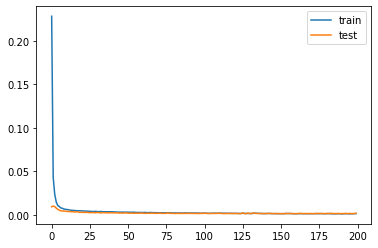

In [ ]:
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Data for encoder**

In [ ]:
# Defining data for input to encoder

df_sentences = df['cleaned_entry'] # sentences in the dataframe
df_sequences = tokenizer.texts_to_sequences(list(df_sentences)) # Converting to sequences
df_padded = pad_sequences(df_sequences,maxlen=max_length, truncating=trunc_type) # Padding the sequences
df_padded_normalized = t.transform(df_padded) # Normalizing the padded sequences

## **Encoder**

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

In [ ]:
# encode the train data
df_padded_encode = encoder.predict(df_padded_normalized)

## **Predict label**

In [ ]:
# Labels

class_legend =  {
    0:'Other BPD',
    1:'Homeless',
    2:'Medical',
    3:'Patron interference',
    4:"Failures",
    6:"Errors",
    8:"Delays",
    9:"Track obstruction",
}

class_legend_cleaned = {i:j.lower() for i,j in zip(class_legend.keys(),class_legend.values())} # Lower word
class_legend_cleaned = {i:porter.stem(j) for i,j in zip(class_legend.keys(),class_legend.values())} # Stem word

In [ ]:
class_sequences = tokenizer.texts_to_sequences(class_legend_cleaned.values())
class_padded = pad_sequences(class_sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
class_encode = encoder.predict(class_padded)

In [ ]:
! pip install sentence_transformers

     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 4.0 MB 34.5 MB/s 
     |████████████████████████████████| 1.2 MB 58.1 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 70.5 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
     |████████████████████████████████| 895 kB 71.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=56f24e9889276717b5c0c8a337b1a3de4ceb084255bd311a7481cc5aa8f71645
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, util

def predict_label_cosine(input_embeddings=df_padded_encode, label_embeddings = class_encode, threshold = 0.3, output_scores=False):

    S = util.pytorch_cos_sim(input_embeddings, label_embeddings)
    
    predicted_labels = []
    predicted_scores = []
    for i in range(input_embeddings.shape[0]):
        label_scores = S[i].tolist()
        scored = sorted(
            zip(class_legend.values(), label_scores),
            key=lambda x: x[1],
            reverse=True
        )
        pred, score = scored[0]
        if threshold is not None and score < threshold:
            pred = "OTHER"
            
        predicted_scores.append(scored)
        predicted_labels.append(pred)        
    
    if output_scores:
        return predicted_labels, predicted_scores
    else:
        return predicted_labels

In [ ]:
df['pred_label_encode'] = predict_label_cosine()
df

,_time,ENTRY,cleaned_entry,pred_label_encode
0,2022-01-28T02:06:00.000-0800,EOR.,eor,Other BPD
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish,OTHER
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish,OTHER
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...,Other BPD
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish,Other BPD
...,...,...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...,kma substat offlin safe clear fix pl ad platform,Other BPD
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central,Other BPD
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.,elin doc,Other BPD
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.,ventil report,Other BPD


In [ ]:
df['pred_label_encode'].value_counts()

Other BPD              657
OTHER                  626
Patron interference     47
Name: pred_label_encode, dtype: int64

It seems that the model is severely biased toward the label 'Other BPD'. The labelling process is proven to be not good. Thus, I suggest that we try another model.




# **K means Clustering model**

This is as a bonus. We can use the encoded "cleaned entry" (i.e., `df_padded_encode`), then cluster them by using k-means.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
class KMeans_model():
  def __init__(self,df):
    self.df = df
  
  def km_score(self,K):
    distortions = []
    silhouette_scores = []

    for k in range(2,K):

      # Introduce kmeans model
      km = KMeans(n_clusters=k)
      km.fit(self.df)

      # Elbow Method
      distortions.append(km.inertia_)

    fig, axs = plt.subplots(1,1, figsize = (12,12))

    # Plotting Elbow Method
    axs.plot(range(2,K), distortions, 'bx-')
    axs.set_title('Elbow Method')
    axs.axvline(x=15) # k is selected at the 'elbow'

  def assign_label(self,k):
    km = KMeans(n_clusters=k, random_state = 88)
    km.fit(self.df)
    result = km.predict(self.df)
    return result

In [ ]:
# Initialize class

km = KMeans_model(df_padded_encode)

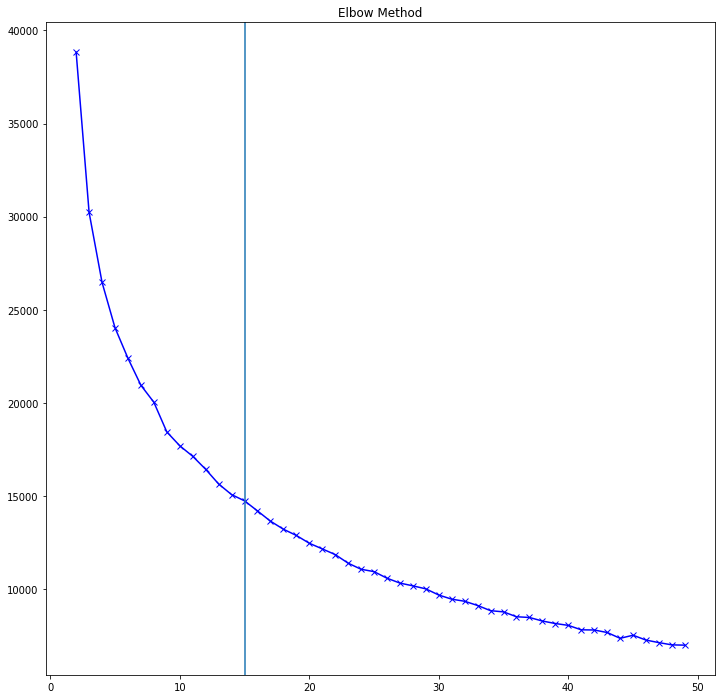

In [ ]:
km.km_score(50)

The elbow is at k = 15. However, k = 15 to be too much (too much labels). Hence I choose k = 5. Feel free to change the k.

In [ ]:
# Predict label using k means
# The input of the function is "k". Feel free to change. 

pred_label = km.assign_label(5)

In [ ]:
# New column in the dataset 'no_label_kmeans'

df['no_label_kmeans'] = pred_label
df

,_time,ENTRY,cleaned_entry,pred_label_encode,no_label_kmeans
0,2022-01-28T02:06:00.000-0800,EOR.,eor,Other BPD,3
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish,OTHER,3
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish,OTHER,3
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...,Other BPD,2
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish,Other BPD,2
...,...,...,...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...,kma substat offlin safe clear fix pl ad platform,Other BPD,2
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central,Other BPD,2
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.,elin doc,Other BPD,2
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.,ventil report,Other BPD,3


The label generated from k-means is not clear. Perhaps the label generated by k-means have certain patterns that can be investigated.